In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
import warnings
import matplotlib.dates as mdates

%matplotlib inline
warnings.filterwarnings("ignore")

In [156]:
data = pd.read_hdf('model1.h5')

In [157]:
data

,date,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv
0,2019-05-10 11:24:00.000,717.51,29.79,60.41
1,2019-05-10 11:24:30.000,735.89,30.51,55.76
2,2019-05-10 11:25:00.000,736.68,31.61,55.89
3,2019-05-10 11:25:30.000,747.61,33.71,56.06
4,2019-05-10 11:26:00.000,747.61,34.68,55.64
...,...,...,...,...
189517,31/10/2019 23:52,795.67,36.52,57.29
189518,31/10/2019 23:57,529.60,34.87,57.40
189519,31/10/2019 23:58,529.87,36.59,57.52
189520,31/10/2019 23:58,530.13,35.19,57.69


### Splitting the data set in train and test sets

In [159]:
train_perc = 0.8
test_perc = 0.2

In [160]:
train_split = int(len(data) * train_perc)
train_data = data[:train_split]

test_split = int(len(data) * test_perc)
test_data = data[train_split:(train_split+test_split+1)]

'\nval_split = int(len(data) * val_perc)\nvalidation_data = data[train_split+test_split:(train_split+test_split+val_split)]\n'

### Filtering so as to get rid of the outlier values

In [163]:
mask2 = (train_data['mill_dp_mbar_pv']>25) & (train_data['mill_dp_mbar_pv']<45) & (train_data['separator_speed_rpm_pv']>600) & (train_data['separator_speed_rpm_pv']<850) & (train_data['separator_pwr_kw_pv']<62)
train_data = train_data[mask2].reset_index(drop=True)

### Turning the date variable into datetime type, turning it to index for the train set grouping by minute.
### Also, we drop it from the test set cause is unneeded

In [164]:
train_data['date'] = pd.to_datetime(train_data['date'], dayfirst=True)
train_data['date'] = train_data['date'].apply(lambda x: x.replace(second=0))
train_data = train_data.groupby(train_data['date']).mean()

In [192]:
test_data.drop(['date'], axis='columns', inplace=True)

### We set the frequency of the by one minute, so as to cover the gaps in the time series
### Then we use interpolation to fill the empty values 

In [166]:
train_data = train_data.asfreq('1T')

In [167]:
train_data = train_data.interpolate(method='linear', axis=0, limit=None, inplace=False, limit_direction='backward', limit_area="inside")

### We shift each input according to their time delay with the output

In [171]:
train_data['separator_speed_rpm_pv'] = train_data['separator_speed_rpm_pv'].shift(periods=2)
train_data['mill_dp_mbar_pv'] = train_data['mill_dp_mbar_pv'].shift(periods=5)
train_data = train_data.iloc[5:]

### Scaling the variable values because they have different ranges

In [4]:
old_columns = train_data.columns

In [5]:
train_data.columns = ['col1', 'col2', 'y']

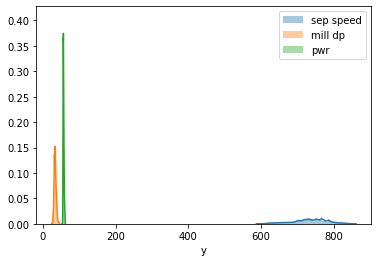

In [6]:
sns.distplot(train_data['col1'], label='sep speed')
sns.distplot(train_data['col2'], label='mill dp')
sns.distplot(train_data['y'], label='pwr')
plt.legend()

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
mm = MinMaxScaler()

train_mm = mm.fit_transform(train_data)

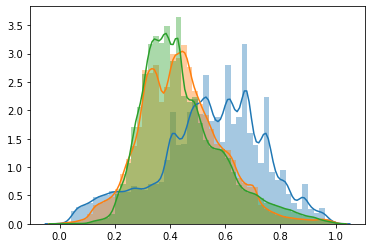

In [9]:
for i in range(3):
    sns.distplot(train_mm[:,i])

### Model evaluation

In [10]:
x = train_data.drop('y', axis=1).values
y = train_data['y'].values

In [11]:
x2 = test_data.drop('separator_pwr_kw_pv', axis=1).values
y2 = test_data['separator_pwr_kw_pv'].values

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [13]:
x = x.copy(order='C')

# Linear Regression
lin_reg = LinearRegression().fit(x, y)
lr_preds = lin_reg.predict(x2)

lr_mae = mean_absolute_error(y2, lr_preds)
lr_mse = np.sqrt(mean_squared_error(y2, lr_preds))
lr_r2 = r2_score(y2, lr_preds, multioutput='variance_weighted')

param_grid = {'alpha': [0.75],
              'solver': ['sag']}

# Ridge
rid_reg = GridSearchCV(Ridge(), param_grid)
rid_reg.fit(x, y)
rd_preds = rid_reg.predict(x2)

rd_mae = mean_absolute_error(y2, rd_preds)
rd_mse = np.sqrt(mean_squared_error(y2, rd_preds))
rd_r2 = r2_score(y2, rd_preds, multioutput='variance_weighted')

In [52]:
# SVR

svr = SVR(max_iter=10000)
svr.fit(x, y)
sv_preds = svr.predict(x2)

sv_mae = mean_absolute_error(y2, sv_preds)
sv_mse = np.sqrt(mean_squared_error(y2, sv_preds))
sv_r2 = r2_score(y2, sv_preds, multioutput='variance_weighted')

In [16]:
param_grid2 = {'min_samples_split': [2],
               'min_samples_leaf': [3]}

# Decision Tree
dt = GridSearchCV(DecisionTreeRegressor(), param_grid2)
dt.fit(x, y)
dt_preds = dt.predict(x2)

dt_mae = mean_absolute_error(y2, dt_preds)
dt_mse = np.sqrt(mean_squared_error(y2, dt_preds))
dt_r2 = r2_score(y2, dt_preds, multioutput='variance_weighted')

In [19]:
param_grid3 = {'n_estimators': [100],
               'min_samples_split': [2],
               'min_samples_leaf': [2]}

# Random Forest
ran_for = GridSearchCV(RandomForestRegressor(), param_grid3)
ran_for.fit(x, y)
rf_preds = ran_for.predict(x2)

rf_mae = mean_absolute_error(y2, rf_preds)
rf_mse = np.sqrt(mean_squared_error(y2, rf_preds))
rf_r2 = r2_score(y2, rf_preds, multioutput='variance_weighted')

In [24]:
param_grid4 = {'loss': ['epsilon_insensitive'],
               'alpha': [0.1],
               'max_iter': [1000],
               'learning_rate': ['optimal']}

# Stohastic Gradient Descent
sgd = GridSearchCV(SGDRegressor(shuffle=False), param_grid4)
sgd.fit(x, y)
sd_preds = sgd.predict(x2)

sd_mae = mean_absolute_error(y2, sd_preds)
sd_mse = np.sqrt(mean_squared_error(y2, sd_preds))
sd_r2 = r2_score(y2, sd_preds, multioutput='variance_weighted')

In [28]:
param_grid5 = {'loss': ['lad'],
               'n_estimators': [100],
               'min_samples_split': [2],
               'min_samples_leaf': [1]}

# Gradient Boosting
gbr = GridSearchCV(GradientBoostingRegressor(), param_grid5)
gbr.fit(x, y)
gb_preds = gbr.predict(x2)

gb_mae = mean_absolute_error(y2, gb_preds)
gb_mse = np.sqrt(mean_squared_error(y2, gb_preds))
gb_r2 = r2_score(y2, gb_preds, multioutput='variance_weighted')

In [33]:
param_grid6 = {'max_iter': [100],
               'min_samples_leaf': [30]}

# Hist Gradient Boosting
hgb = GridSearchCV(HistGradientBoostingRegressor(), param_grid6)
hgb.fit(x, y)
hg_preds = hgb.predict(x2)

hg_mae = mean_absolute_error(y2, hg_preds)
hg_mse = np.sqrt(mean_squared_error(y2, hg_preds))
hg_r2 = r2_score(y2, hg_preds, multioutput='variance_weighted')

In [37]:
param_grid7 = {'n_estimators': [100]}

# Bagging
bag = GridSearchCV(BaggingRegressor(), param_grid7)
bag.fit(x, y)
bg_preds = bag.predict(x2)

bg_mae = mean_absolute_error(y2, bg_preds)
bg_mse = np.sqrt(mean_squared_error(y2, bg_preds))
bg_r2 = r2_score(y2, bg_preds, multioutput='variance_weighted')

### Printing the results

In [53]:
print('Linear Regression: ', lr_mae, lr_mse, lr_r2)
print('Ridge Regression:  ', rd_mae, rd_mse, rd_r2)
print('Suppport Vector:   ', sv_mae, sv_mse, sv_r2)
print('Decision Tree:     ', dt_mae, dt_mse, dt_r2)
print('Random Forest:     ', rf_mae, rf_mse, rf_r2)
print('Gradient Descent:  ', sd_mae, sd_mse, sd_r2)
print('Gradient Boosting: ', gb_mae, gb_mse, gb_r2)
print('Hist Grad Boost:   ', hg_mae, hg_mse, hg_r2)
print('Bagging:           ', bg_mae, bg_mse, bg_r2)

Linear Regression:  1.0557267212603263 1.9585802034085076 0.11475007362684098
Ridge Regression:   1.0554569136830576 1.9583629601131585 0.11494644439095734
Suppport Vector:    1.1447391503126574 2.046010118915327 0.033951939732638214
Decision Tree:      1.2187794129400826 2.08446466771502 -0.002702861918375987
Random Forest:      1.094758792016865 1.9683291231128062 0.10591539929230652
Gradient Descent:   1.7122862108590338 3.2939536296716065 -1.5039066902557718
Gradient Boosting:  1.0167013537215344 1.8900919183478833 0.1755790325935056
Hist Grad Boost:    1.0352598190149567 1.901949029319266 0.16520291031465417
Bagging:            1.1067461367186695 1.9803217388771088 0.09498726978822436


### Plotting the best 3 models in comparison with the real values

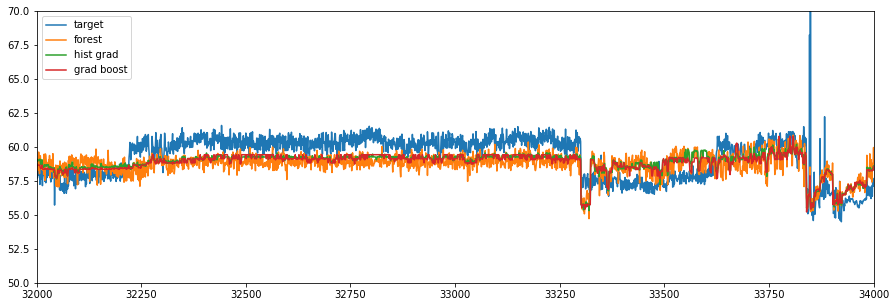

In [88]:
plt.figure(figsize=(15, 5))

plt.plot(range(len(y2)), y2, label='target')
plt.plot(range(len(y2)), rf_preds, label='forest')
plt.plot(range(len(y2)), hg_preds, label='hist grad')
plt.plot(range(len(y2)), gb_preds, label='grad boost')

plt.xlim(32000, 34000)
plt.ylim(50, 70)

plt.legend()